In [2]:
import pandas as pd
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from random import shuffle
from nltk.stem import PorterStemmer
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import pymc3 as pm

In [3]:
def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

I want to see if you can estimate a speaker's vocabulary from a sample of their text by plotting word count vs unique words and then calculating an asymptote:

In [4]:
stop = stopwords.words('english') + list(string.punctuation) + ['’']
# stop = list(string.punctuation) + ['’']

def get_tokens(text):
    tokens_text = [i for i in word_tokenize(text.lower()) if i not in stop and not is_number(i)]
    return tokens_text

In [5]:
uk_pol_final = pd.read_csv('uk_pol_final.csv')

In [6]:
uk_pol_final.shape

(2600, 5)

In [7]:
uk_pol_final.head(1)

,speaker,party,date,subject,text
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,The Chartered Institute of Housing Cymru state...


In [8]:
uk_pol_final['tokenized'] = uk_pol_final.text.map(lambda x: get_tokens(x))

In [9]:
uk_pol_final.speaker.value_counts()[:20]

David Cameron        178
Theresa May          152
Matthew Hancock       62
George Osborne        56
Gordon Brown          55
William Hague         49
Michael Gove          48
Sajid Javid           44
Ed Miliband           40
Nick Gibb             40
John Major            38
Nick Clegg            37
Jeremy Corbyn         36
Alan Milburn          35
Tony Blair            34
John Hutton           34
Jeremy Hunt           34
Iain Duncan Smith     32
Justine Greening      30
Boris Johnson         28
Name: speaker, dtype: int64

In [10]:
uk_pol_final[uk_pol_final.speaker=='David Cameron'].iloc[2,5]

['standing',
 'today',
 'want',
 'lead',
 'conservative',
 'party',
 'want',
 'lead',
 'victory',
 'next',
 'general',
 'election',
 'say',
 'bit',
 'young',
 'say',
 'parliament',
 'five',
 'years',
 'maybe',
 'experience',
 'job',
 'ways',
 'right',
 'years',
 'old',
 'parliament',
 'five',
 'years',
 'believe',
 'got',
 'right',
 'ideas',
 'head',
 'right',
 'passion',
 'heart',
 'know',
 'party',
 'needs',
 'change',
 'go',
 'people',
 'say',
 'labour',
 'party',
 'gordon',
 'brown',
 'move',
 'left',
 'economy',
 'going',
 'hit',
 'rocks',
 'got',
 'wait',
 'give',
 'one',
 'heave',
 'think',
 'rubbish',
 'think',
 'would',
 'pathetic',
 'way',
 'great',
 'party',
 'like',
 'behave',
 'people',
 'say',
 'got',
 'attack',
 'government',
 'bit',
 'vigour',
 'got',
 'pull',
 'apart',
 'little',
 'bit',
 'say',
 'wrong',
 'already',
 'called',
 'tony',
 'blair',
 'liar',
 'problem',
 'last',
 'election',
 'people',
 'trusted',
 'labour',
 'party',
 'got',
 'lowest',
 'level',
 'suppor

In [11]:
dc_text = []

for i, row in uk_pol_final[uk_pol_final.speaker=='David Cameron'].iterrows():
    dc_text += row.tokenized

In [12]:
len(dc_text)

205650

In [13]:
len(set(dc_text))

14022

In [14]:
dc_vocab = []
for i in range(0,len(dc_text),100):
    dc_vocab.append([i,len(set(dc_text[:i]))])

In [15]:
import numpy as np

In [16]:
dc_df = pd.DataFrame(np.array(dc_vocab),columns=['words','unique_words'])
# dc_df.set_index('words',inplace=True)

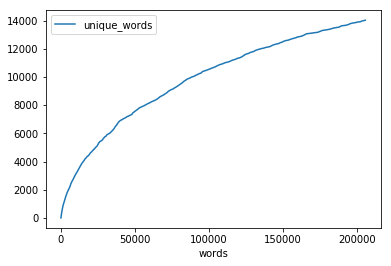

In [18]:
dc_df.set_index('words').plot();

If I can fit a model based on 1/[words] then the intercept of that model should be the asymptote of the graph above, which will be the upper limit of the speaker's unique word count.

In [19]:
from sklearn.linear_model import LinearRegression

In [27]:
dc_df.head()

,words,unique_words
0,0,0
1,100,84
2,200,152
3,300,226
4,400,300


In [28]:
dc_df['words_inverse'] = dc_df.words.map(lambda x: 1/x if x>0 else 0)

In [29]:
dc_df.head()

,words,unique_words,words_inverse
0,0,0,0.000000
1,100,84,0.010000
2,200,152,0.005000
3,300,226,0.003333
4,400,300,0.002500


In [21]:
X = dc_df[['words_inverse']]
y = dc_df.unique_words

linreg = LinearRegression()
linreg.fit(X,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
print(linreg.intercept_)

9944.435589941628


In [41]:
linreg.coef_

array([-3283436.28261312])

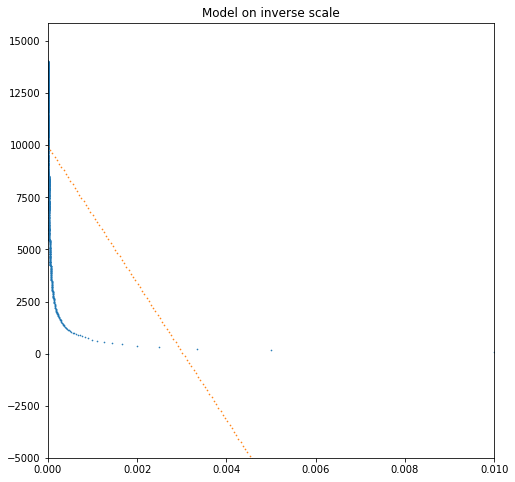

In [42]:
x = np.linspace(0,X.max(),200)
y = linreg.intercept_ + linreg.coef_[0]*x

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words_inverse, y=dc_df.unique_words, s=0.4)
ax.scatter(x=x, y=y, s=0.4)

ax.set_title('Model on inverse scale')

ax.set_xlim(0,0.01)
ax.set_ybound(-5000)

plt.show();

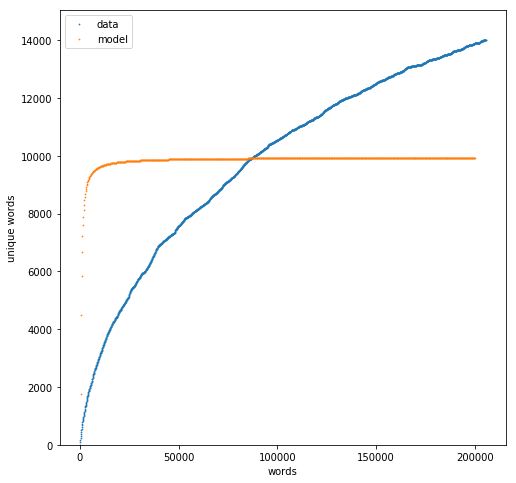

In [43]:
x = np.linspace(0,200000,1000)
y = linreg.intercept_ + linreg.coef_[0]/x

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words, y=dc_df.unique_words, s=0.5, label='data')
ax.scatter(x=x, y=y, s=0.5, label='model')

ax.set_xlabel('words')
ax.set_ylabel('unique words')
ax.legend()

ax.set_title('Model on normal scale')

ax.set_ybound(0)

plt.show();

The model came back at a number significantly less than the highest unique count from the data, so that didn't work.

11462.183247984955


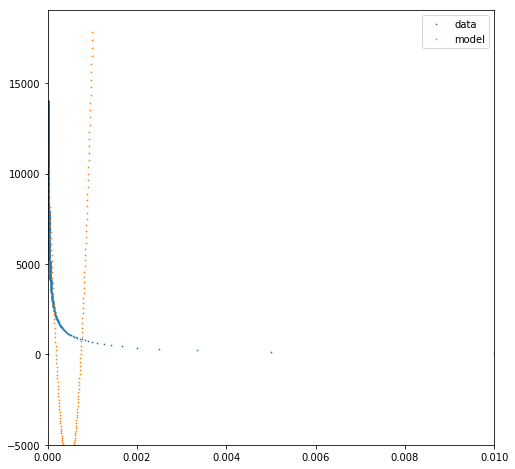

In [54]:
dc_df['words_inverse_2'] = dc_df.words.map(lambda x: 1/(x**2) if x>0 else 0)
X = dc_df[['words_inverse','words_inverse_2']][10:]
y = dc_df.unique_words[10:]

linreg = LinearRegression()
linreg.fit(X,y)

print(linreg.intercept_)

x = np.linspace(0,X.max()[0],200)
y = linreg.intercept_ + linreg.coef_[0]*x + linreg.coef_[1]*(x**2)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words_inverse, y=dc_df.unique_words, s=0.5, label='data')
ax.scatter(x=x, y=y, s=0.5, label='model')

ax.legend()
ax.set_title('Polynomial model on inverse scale')

ax.set_xlim(0,0.01)
ax.set_ybound(-5000)

plt.show();

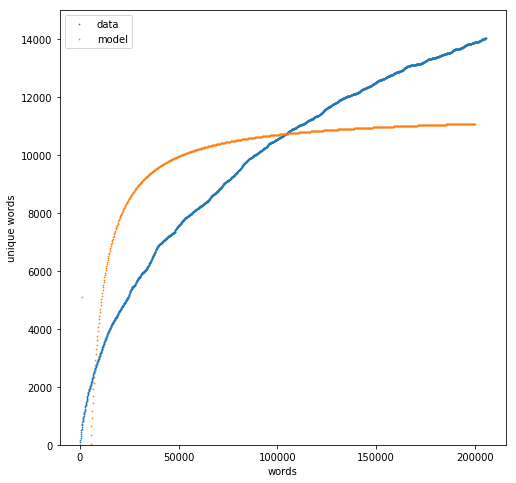

In [55]:
x = np.linspace(0,200000,1000)
y = linreg.intercept_ + linreg.coef_[0]/x + linreg.coef_[1]/(x**2)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words, y=dc_df.unique_words, s=0.5, label='data')
ax.scatter(x=x, y=y, s=0.5, label='model')

ax.set_xlabel('words')
ax.set_ylabel('unique words')
ax.legend()
ax.set_title('Polynomial model on normal scale')

# ax.set_xlim(0,0.01)
ax.set_ylim(0,15000)

plt.show();

Adding a polynomnial feature has brought the intercept closer to the maximum observed unique word count but it's still lower. I'll try excluding some data from the start of the dataframe:

10616.154122374059


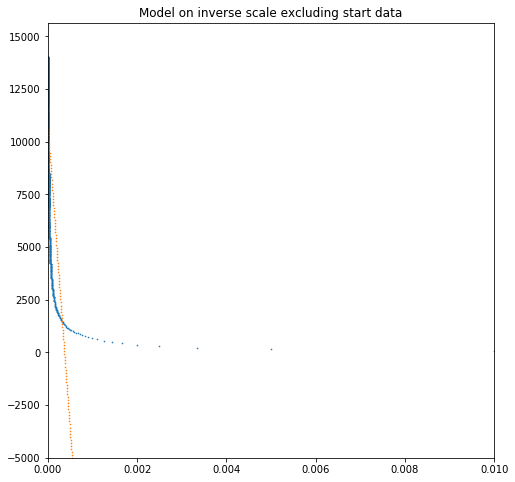

In [56]:
X = dc_df[['words_inverse']][10:]
y = dc_df.unique_words[10:]

linreg = LinearRegression()
linreg.fit(X,y)

print(linreg.intercept_)

x = np.linspace(0,X.max(),200)
y = linreg.intercept_ + linreg.coef_[0]*x

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words_inverse, y=dc_df.unique_words, s=0.4)
ax.scatter(x=x, y=y, s=0.4)

ax.set_title('Model on inverse scale excluding start data')

ax.set_xlim(0,0.01)
ax.set_ybound(-5000)

plt.show();

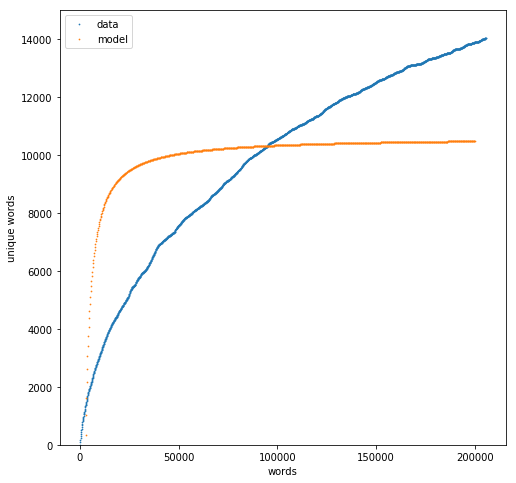

In [57]:
x = np.linspace(0,200000,1000)
y = linreg.intercept_ + linreg.coef_[0]/x

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.words, y=dc_df.unique_words, s=0.5, label='data')
ax.scatter(x=x, y=y, s=0.5, label='model')

ax.set_xlabel('words')
ax.set_ylabel('unique words')
ax.legend()
ax.set_title('Model on normal scale excluding start data')

# ax.set_xlim(0,15000)
ax.set_ylim(0,15000)

plt.show();

I don't think this approach is going to give me any meaningful results to be honest. I'll try plotting the curves for a few speakers and see what I get:

In [27]:
def unique_words(name):
    speaker_text = []
    for i, row in uk_pol_final[uk_pol_final.speaker==name].iterrows():
        speaker_text += row.tokenized
        
#   I realised that the graphs were looking a bit wobbly. shuffling the text smoothd them out.
    shuffle(speaker_text)
    
    speaker_vocab = []
    for i in range(0,len(speaker_text),100):
        speaker_vocab.append([i,len(set(speaker_text[:i]))])

    speaker_df = pd.DataFrame(np.array(speaker_vocab),columns=['words','unique_words'])
    speaker_df.set_index('words',inplace=True)
    
    return speaker_df

In [28]:
dc_df = unique_words('David Cameron')

In [29]:
tm_df = unique_words('Theresa May')

In [30]:
gb_df = unique_words('Gordon Brown')

In [31]:
tb_df = unique_words('Tony Blair')

In [32]:
wh_df = unique_words('William Hague')

In [33]:
em_df = unique_words('Ed Miliband')

In [34]:
mg_df = unique_words('Michael Gove')

In [35]:
nc_df = unique_words('Nick Clegg')

In [36]:
jc_df = unique_words('Jeremy Corbyn')

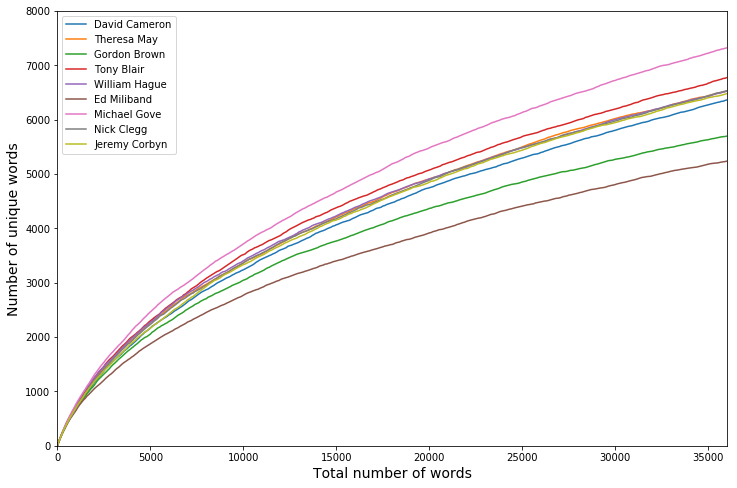

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(dc_df, label='David Cameron')
ax.plot(tm_df, label='Theresa May')
ax.plot(gb_df, label='Gordon Brown')
ax.plot(tb_df, label='Tony Blair')
ax.plot(wh_df, label='William Hague')
ax.plot(em_df, label='Ed Miliband')
ax.plot(mg_df, label='Michael Gove')
ax.plot(nc_df, label='Nick Clegg')
ax.plot(jc_df, label='Jeremy Corbyn')

ax.legend()
ax.set_xlim(0,36000)
ax.set_ylim(0,8000)

ax.set_xlabel('Total number of words',fontsize=14)
ax.set_ylabel('Number of unique words',fontsize=14)

plt.legend()

plt.show();

In [38]:
uk_pol_final.head(1)

,speaker,party,date,subject,text,tokenized
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,The Chartered Institute of Housing Cymru state...,"[chartered, institute, housing, cymru, states,..."


In [39]:
uk_pol_final['token_count'] = uk_pol_final.tokenized.map(lambda x: len(x))

In [40]:
uk_pol_final.head(1)

,speaker,party,date,subject,text,tokenized,token_count
0,Mark Isherwood,Conservative,2006-01-10,Fuel Poverty,The Chartered Institute of Housing Cymru state...,"[chartered, institute, housing, cymru, states,...",480


I think the only way to get anything meaningful from this is to just use the unique word count from an arbitrary length randomised sample of text for each speaker. From the graph above we can see that the unique word counts are pretty well differentiated after the first few thousand words. I'll pick a value so we get a decent spread of parties.

In [41]:
uk_pol_final.groupby(['speaker','party'])['token_count'].sum().sort_values(ascending=False)[:35]

speaker            party       
David Cameron      Conservative    205650
Theresa May        Conservative    145920
Gordon Brown       Labour          101634
George Osborne     Conservative     99856
Michael Gove       Conservative     78556
Alan Milburn       Labour           61780
John Major         Conservative     56280
William Hague      Conservative     56161
Matthew Hancock    Conservative     51188
Ed Miliband        Labour           47597
Nick Clegg         Lib Dem          45869
Jeremy Corbyn      Labour           45383
Nick Gibb          Conservative     43298
Iain Duncan Smith  Conservative     38340
Tony Blair         Labour           38091
Sajid Javid        Conservative     37219
Jeremy Hunt        Conservative     36458
John Hutton        Labour           36321
David Blunkett     Labour           29968
Justine Greening   Conservative     28238
Philip Hammond     Conservative     27700
Nicky Morgan       Conservative     27415
Liam Fox           Conservative     26757
Ed

In [42]:
top_token_counts = pd.DataFrame(uk_pol_final.groupby(['speaker','party'])['token_count'].sum().sort_values(ascending=False)[:35])

In [43]:
vocab_speakers = top_token_counts.reset_index()['speaker']

In [44]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

for word in ['active', 'activate', 'activating']:
    print(stemmer.stem(word))

activ
activ
activ


In [45]:
stemmer = PorterStemmer()

def unique_words_sample(name, sample_size, df):
    speaker_text = []
    for i, row in df[df.speaker==name].iterrows():
        speaker_text += row.tokenized
        
#   I realised that the graphs were looking a bit wobbly. shuffling the text smoothed them out.
#   Also, re-running this gave slightly different results so I'm going to run it 5 times and take the mean.
    samples = []
    samples_unique = []
    for sample in range(5):
        
        shuffle(speaker_text)
        stemmed_text = [stemmer.stem(word) for word in speaker_text]
        text_sample = stemmed_text[:sample_size]
        samples.append(len(text_sample))
        samples_unique.append(len(set(text_sample)))
    
#   need to check that we've actually got the required number of words after stemming
    word_count = int(np.mean(samples))
    unique_count = int(np.mean(samples_unique))
    party = df[df.speaker==name].iloc[0].party
    
    return party, word_count, unique_count

In [46]:
vocab = {}
vocab['name'] = []
vocab['party'] = []
vocab['word_count'] = []
vocab['unique_count'] = []

for name in vocab_speakers:
    party, word_count, unique_count = unique_words_sample(name, 15000, uk_pol_final)
    vocab['name'].append(name)
    vocab['party'].append(party)
    vocab['word_count'].append(word_count)
    vocab['unique_count'].append(unique_count)

In [47]:
vocab_df = pd.DataFrame(vocab)

In [48]:
vocab_df

,name,party,word_count,unique_count
0,David Cameron,Conservative,15000,3020
1,Theresa May,Conservative,15000,3027
2,Gordon Brown,Labour,15000,2637
3,George Osborne,Conservative,15000,2800
4,Michael Gove,Conservative,15000,3350
5,Alan Milburn,Labour,15000,2302
6,John Major,Conservative,15000,3197
7,William Hague,Conservative,15000,3060
8,Matthew Hancock,Conservative,15000,3051
9,Ed Miliband,Labour,15000,2487


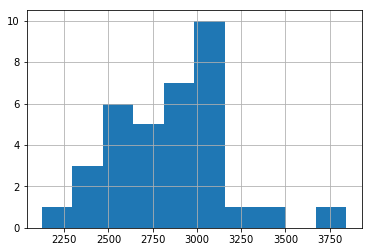

In [49]:
vocab_df.unique_count.hist();

In [50]:
vocab_df['bin'] = pd.cut(vocab_df.unique_count,20)
vocab_df['bin_mid'] = vocab_df.bin.map(lambda x: np.round(x.mid,-2))
vocab_df['ranking'] = vocab_df.sort_values('unique_count').groupby('bin_mid').cumcount()
vocab_df['st_rank'] = vocab_df.groupby('bin_mid').ranking.apply(lambda x: x-x.mean())

In [51]:
vocab_df[vocab_df.bin_mid==2900]

,name,party,word_count,unique_count,bin,bin_mid,ranking,st_rank
12,Nick Gibb,Conservative,15000,2923,"(2899.0, 2985.0]",2900.0,4,0.5
15,Sajid Javid,Conservative,15000,2960,"(2899.0, 2985.0]",2900.0,6,2.5
16,Jeremy Hunt,Conservative,15000,2985,"(2899.0, 2985.0]",2900.0,7,3.5
18,David Blunkett,Labour,15000,2826,"(2813.0, 2899.0]",2900.0,0,-3.5
20,Philip Hammond,Conservative,15000,2942,"(2899.0, 2985.0]",2900.0,5,1.5
22,Liam Fox,Conservative,15000,2917,"(2899.0, 2985.0]",2900.0,3,-0.5
27,David Lidington,Conservative,15000,2902,"(2899.0, 2985.0]",2900.0,2,-1.5
29,Michael Fallon,Conservative,15000,2846,"(2813.0, 2899.0]",2900.0,1,-2.5


In [52]:
vocab_df

,name,party,word_count,unique_count,bin,bin_mid,ranking,st_rank
0,David Cameron,Conservative,15000,3020,"(2985.0, 3071.0]",3000.0,1,-2.0
1,Theresa May,Conservative,15000,3027,"(2985.0, 3071.0]",3000.0,2,-1.0
2,Gordon Brown,Labour,15000,2637,"(2555.0, 2641.0]",2600.0,1,0.5
3,George Osborne,Conservative,15000,2800,"(2727.0, 2813.0]",2800.0,2,0.5
4,Michael Gove,Conservative,15000,3350,"(3329.0, 3415.0]",3400.0,0,0.0
5,Alan Milburn,Labour,15000,2302,"(2297.0, 2383.0]",2300.0,0,0.0
6,John Major,Conservative,15000,3197,"(3157.0, 3243.0]",3200.0,0,0.0
7,William Hague,Conservative,15000,3060,"(2985.0, 3071.0]",3000.0,5,2.0
8,Matthew Hancock,Conservative,15000,3051,"(2985.0, 3071.0]",3000.0,4,1.0
9,Ed Miliband,Labour,15000,2487,"(2469.0, 2555.0]",2500.0,0,-1.5


In [53]:
color_dict = {'Conservative':'#0087DC',
              'Labour':'#DC241f',
              'Lib Dem':'#FAA61A'}

color_list = vocab_df.party.map(lambda x: color_dict[x])

In [54]:
vocab_df

,name,party,word_count,unique_count,bin,bin_mid,ranking,st_rank
0,David Cameron,Conservative,15000,3020,"(2985.0, 3071.0]",3000.0,1,-2.0
1,Theresa May,Conservative,15000,3027,"(2985.0, 3071.0]",3000.0,2,-1.0
2,Gordon Brown,Labour,15000,2637,"(2555.0, 2641.0]",2600.0,1,0.5
3,George Osborne,Conservative,15000,2800,"(2727.0, 2813.0]",2800.0,2,0.5
4,Michael Gove,Conservative,15000,3350,"(3329.0, 3415.0]",3400.0,0,0.0
5,Alan Milburn,Labour,15000,2302,"(2297.0, 2383.0]",2300.0,0,0.0
6,John Major,Conservative,15000,3197,"(3157.0, 3243.0]",3200.0,0,0.0
7,William Hague,Conservative,15000,3060,"(2985.0, 3071.0]",3000.0,5,2.0
8,Matthew Hancock,Conservative,15000,3051,"(2985.0, 3071.0]",3000.0,4,1.0
9,Ed Miliband,Labour,15000,2487,"(2469.0, 2555.0]",2500.0,0,-1.5


In [55]:
vocab_df.bin_mid.sort_values().unique().astype(int)

array([2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3400, 3800])

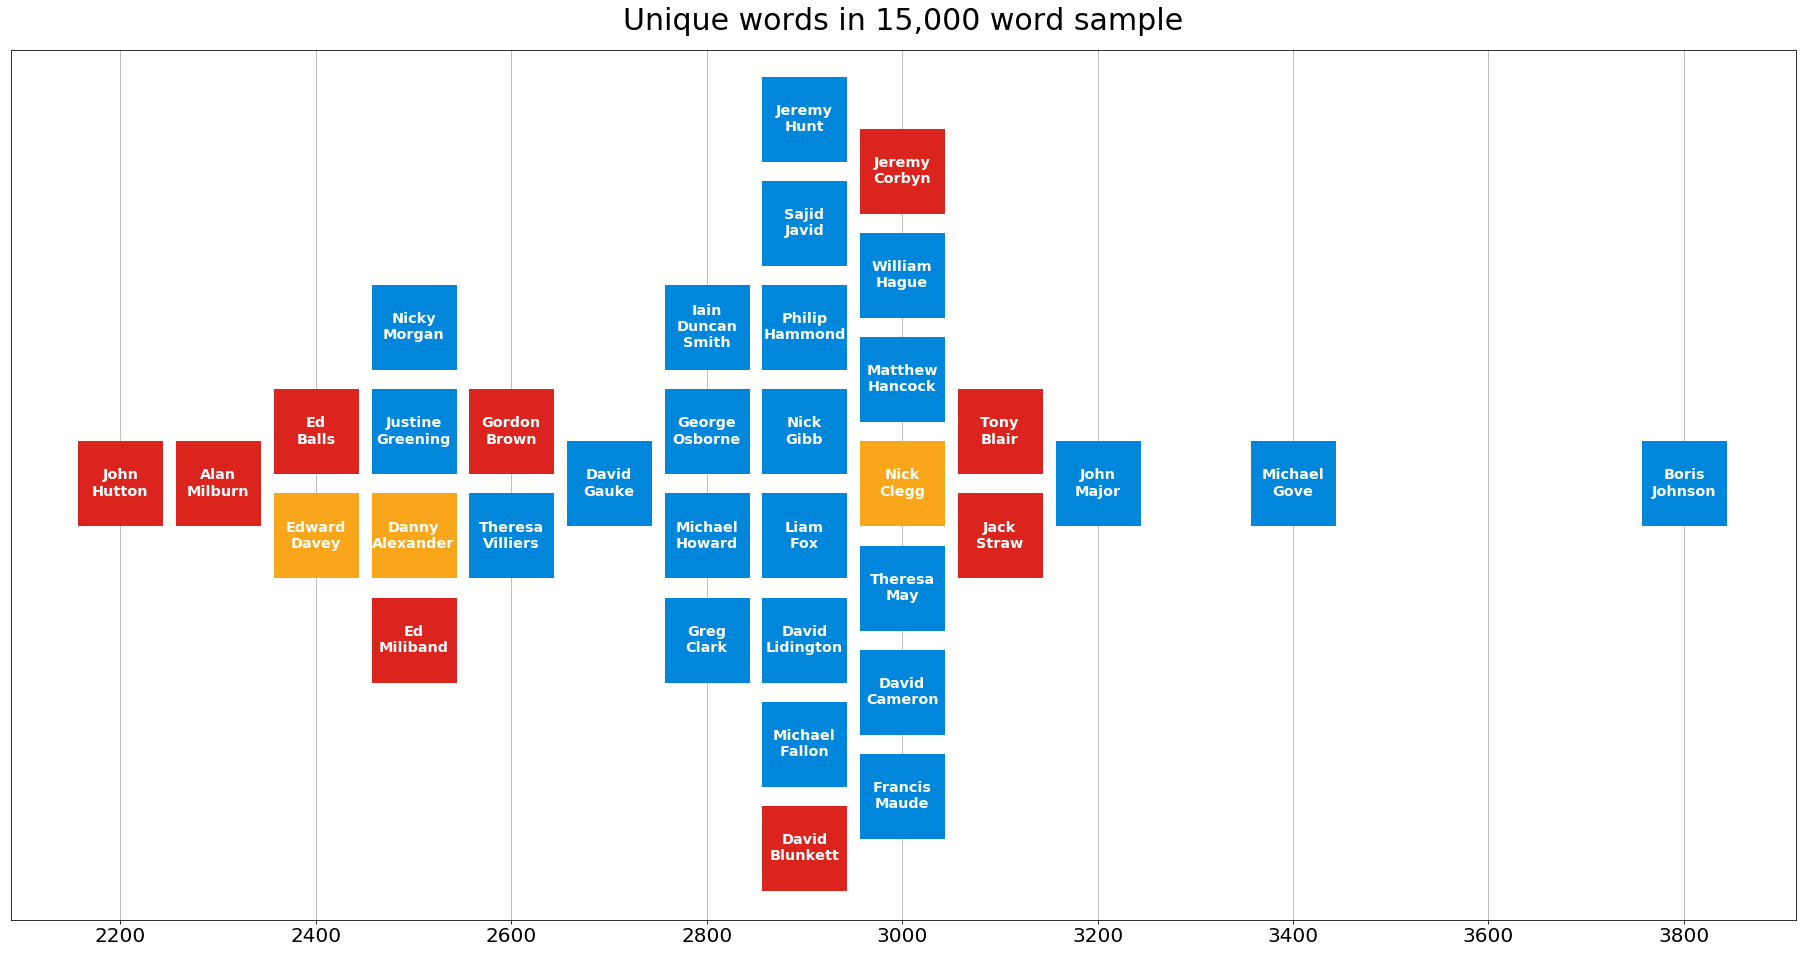

In [56]:
rcParams['axes.titlepad']=20

fig, ax = plt.subplots(figsize=(32,16))

for i, row in vocab_df.iterrows():
#     marker_name = '{}\n{}'.format(row['name'].split(' ')[0],row['name'].split(' ')[1])
    marker_name = '\n'.join(row['name'].split(' '))
    ax.scatter(x=row.bin_mid, 
               y=row.st_rank, 
               color=color_dict[row.party], 
               s=7000, marker='s')
    plt.annotate(marker_name, xy=(row.bin_mid, row.st_rank), 
                 horizontalalignment='center',
                 verticalalignment='center',fontsize='x-large',color='white',fontweight='bold')



# ax.scatter(x=vocab_df.bin_mid, y=vocab_df.st_rank, color=color_list, s=200, marker=vocab_df.name)

bins = vocab_df.bin_mid.sort_values().unique().astype(int)
bin_ticks = np.arange(bins.min(),bins.max()+1,200)

ax.set_yticks([])
ax.set_title('Unique words in 15,000 word sample', fontsize=30)
# ax.set_xlabel('Unique words in 15,000 word sample', fontsize=26)
ax.set_xticks(bin_ticks)
ax.set_xticklabels(bin_ticks, fontsize=20)
ax.xaxis.grid(True)
ax.set_axisbelow(True)

plt.show();

That looks like Labour speakers tend to have a lower lexical diversity than Conservative speakers. I'll see if I can use pymc3 to calculate if it's a significant difference. This will mean taking a smaller sample than 15,000 words so we can get as many speakers as poss.

In [57]:
uk_pol_conlab = uk_pol_final[(uk_pol_final.party=='Conservative')|(uk_pol_final.party=='Labour')]

In [58]:
conlab_speakers = uk_pol_conlab.speaker.unique()

In [59]:
vocab = {}
vocab['name'] = []
vocab['party'] = []
vocab['word_count'] = []
vocab['unique_count'] = []

for name in conlab_speakers:
    party, word_count, unique_count = unique_words_sample(name, 10000, uk_pol_conlab)
    vocab['name'].append(name)
    vocab['party'].append(party)
    vocab['word_count'].append(word_count)
    vocab['unique_count'].append(unique_count)

In [60]:
vocab_df2 = pd.DataFrame(vocab)

In [61]:
vocab_df2.head()

,name,party,word_count,unique_count
0,Mark Isherwood,Conservative,480,297
1,Chuka Umunna,Labour,8567,2180
2,Nadhim Zahawi,Conservative,1412,554
3,Daniel Zeichner,Labour,1896,837
4,Konni Zilliacus,Labour,2399,906


In [62]:
vocab_df2[vocab_df2.word_count>=4000].party.value_counts()

Conservative    78
Labour          30
Name: party, dtype: int64

If we take a word sample of 4000 we get at least 30 speakers in each group. From the graph this seems like it will give us reasonably separated results.

In [63]:
vocab = {}
vocab['name'] = []
vocab['party'] = []
vocab['word_count'] = []
vocab['unique_count'] = []

for name in conlab_speakers:
    party, word_count, unique_count = unique_words_sample(name, 4000, uk_pol_conlab)
    vocab['name'].append(name)
    vocab['party'].append(party)
    vocab['word_count'].append(word_count)
    vocab['unique_count'].append(unique_count)

vocab_df2 = pd.DataFrame(vocab)
vocab_df2[vocab_df2.word_count>=4000].party.value_counts()

Conservative    78
Labour          30
Name: party, dtype: int64

In [64]:
vocab_df2_top = vocab_df2[vocab_df2.word_count==4000]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


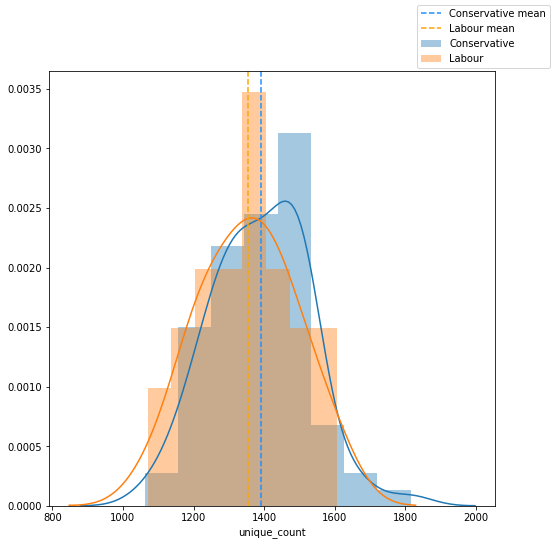

In [65]:
fig, ax = plt.subplots(figsize=(8,8))

sns.distplot(vocab_df2_top[vocab_df2_top.party=='Conservative'].unique_count, bins=8, ax=ax)
sns.distplot(vocab_df2_top[vocab_df2_top.party=='Labour'].unique_count, bins=8, ax=ax)

ax.axvline(vocab_df2_top[vocab_df2_top.party=='Conservative'].unique_count.mean(), c='dodgerblue', ls='--')
ax.axvline(vocab_df2_top[vocab_df2_top.party=='Labour'].unique_count.mean(), c='orange', ls='--')

fig.legend(labels=['Conservative mean','Labour mean','Conservative','Labour'])

plt.show;

The two distributions are pretty closely matched to be honest, I don't think we'll find a significant difference.

In [66]:
conlab_mean = vocab_df2_top.unique_count.mean()
conlab_std = vocab_df2_top.unique_count.std()

std_prior_lower = 1.
std_prior_upper = 1000.

con_unique = vocab_df2_top[vocab_df2_top.party=='Conservative'].unique_count
lab_unique = vocab_df2_top[vocab_df2_top.party=='Labour'].unique_count

In [67]:
with pm.Model() as conlab_model:

    con_mean = pm.Normal('con_mean', mu=conlab_mean, sd=conlab_std)
    lab_mean = pm.Normal('lab_mean', mu=conlab_mean, sd=conlab_std)
    
    con_std = pm.Uniform('con_std', lower=std_prior_lower, upper=std_prior_upper)
    lab_std = pm.Uniform('lab_std', lower=std_prior_lower, upper=std_prior_upper)
    
    con = pm.Normal('con', mu=con_mean, sd=con_std, observed=con_unique)
    lab = pm.Normal('lab', mu=lab_mean, sd=lab_std, observed=lab_unique)
    
    diff_of_means = pm.Deterministic('mean_diff', con_mean - lab_mean)

In [68]:
with conlab_model:
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lab_std, con_std, lab_mean, con_mean]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1263.13draws/s]


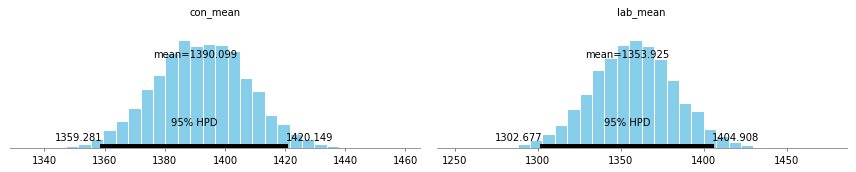

In [69]:
pm.plot_posterior(trace[500:],
                  varnames=['con_mean', 'lab_mean'],
                  color='#87ceeb')
plt.show()

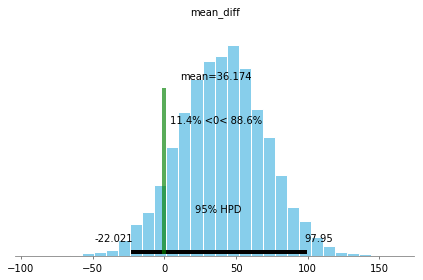

In [70]:
pm.plot_posterior(trace[500:],
                  varnames=['mean_diff'],
                  color='#87ceeb', ref_val=0)
plt.show()

In [73]:
pm.diagnostics.gelman_rubin(trace)

{'con_mean': 0.9999036470670642,
 'lab_mean': 0.9999141888722726,
 'con_std': 0.9999217917493602,
 'lab_std': 0.9999206100461677,
 'mean_diff': 0.9999177280884699}

Although the mean number of unique words is higher for Conservative speakers than Labour speakers, the difference falls within the 95% interval so we can't say that there's a significant difference.

## Going back to estimating the total vocab:
I did a bit more thinking and refined my earlier formula for approximating the vocabulary:

In [71]:
dc_df.head()

,unique_words
words,
0,0
100,98
200,180
300,262
400,331


581234.3715916047
0.9708900473584533


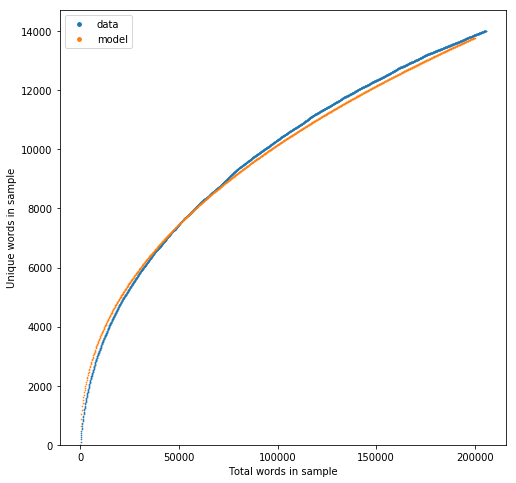

In [72]:
a=10000
power=0.45

def my_funct(x):
    return (1-a/((x**power)+a))

dc_df['new_x'] = dc_df.index.map(lambda x: my_funct(x))
X = dc_df[['new_x']]
y = dc_df.unique_words

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.5)

linreg = LinearRegression(fit_intercept=False)
linreg.fit(X_train,y_train)

funct_x = np.linspace(0,200000,1000)
funct_y = linreg.coef_[0]*(my_funct(x))

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x=dc_df.index, y=dc_df.unique_words, s=0.4, label='data')
ax.scatter(x=funct_x, y=funct_y, s=0.4, label='model')

ax.set_ybound(0)

ax.set_xlabel('Total words in sample')
ax.set_ylabel('Unique words in sample')

plt.legend(markerscale=6)

print(linreg.coef_[0])
print(linreg.score(X_test,y_test))
plt.show();

So, for the data I've got I can fit a model with almost perfect train split R$^2$ score based on:<p>
$$y=\beta \biggl(1-\frac{10,000}{x^{0.45}+10,000}\biggr)$$<p>
In this model, $y$ (unique words in sample) tends to $\beta$ as $x$ (total words in sample) tends to infinity, meaning that $\beta$ represents the speaker's vocabulary. However, fitting this model to David Cameron's sampled speeches calculates his vocabulary at almost 600,000 words, about 20 times the vocabulary of most people.<p>
I am sure that this is not correct, and since this was the best model I could fit to the data I've got to conclude that I'm not able to build a model to approximate a speaker's vocabulary from a sample of their speeches/writing.